## Import library

In [1]:
%run bert
%run utils.ipynb
%run feat
import re
import string
import numpy as np
import pandas as pd
import sklearn as sk 
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score,mean_absolute_error,mean_squared_error,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna

In [2]:
loader = DataLoader()
d = loader.GetData('ASAP')
d = d.loc[d['essay_set'] ==1]
d.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # Remove non-Roman characters
    text = re.sub("([^\x00-\x7F])+", " ", text)    
    text = re.sub("[\n\r\t]", " ", text)   
    return text
t = [clean_text(i) for i in d['essay']]

19m27.4s

In [8]:
EmbeddingFetcher = GetBERTEmbeddings(d['essay'],'model/deberta-v3-large')
EmbeddingFetcher.inf(stop=1500,SeqLen = 512 )

tokenized
0/1500, run:0
10/1500, run:0
20/1500, run:0
30/1500, run:0
40/1500, run:0
50/1500, run:0
60/1500, run:0
70/1500, run:0
80/1500, run:0
90/1500, run:0
100/1500, run:0
110/1500, run:0
120/1500, run:0
130/1500, run:0
140/1500, run:0
150/1500, run:0
160/1500, run:0
170/1500, run:0
180/1500, run:0
190/1500, run:0
200/1500, run:0
210/1500, run:0
220/1500, run:0
230/1500, run:0
240/1500, run:0
250/1500, run:0
260/1500, run:0
270/1500, run:0
280/1500, run:0
290/1500, run:0
300/1500, run:0
310/1500, run:0
320/1500, run:0
330/1500, run:0
340/1500, run:0
350/1500, run:0
360/1500, run:0
370/1500, run:0
380/1500, run:0
390/1500, run:0
400/1500, run:0
410/1500, run:0
420/1500, run:0
430/1500, run:0
440/1500, run:0
450/1500, run:0
460/1500, run:0
470/1500, run:0
480/1500, run:0
490/1500, run:0
500/1500, run:0
510/1500, run:0
520/1500, run:0
530/1500, run:0
540/1500, run:0
550/1500, run:0
560/1500, run:0
570/1500, run:0
580/1500, run:0
590/1500, run:0
600/1500, run:0
610/1500, run:0
620/1500,

In [9]:
del EmbeddingFetcher.model
torch.cuda.empty_cache()

In [31]:
x = EmbeddingFetcher.GetEmbeddings('CLS')

In [32]:
x = [np.array(i).reshape(1024) for i in x]
TrainX,TestX = np.array(x[:1200]),np.array(x[1200:])

In [33]:
le = LabelEncoder()
le.fit(d['domain1_score'])
y = le.transform(d['domain1_score']) 
TrainY,TestY = y[:1200],y[1200:]

In [34]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=11,learning_rate=0.042)
model.fit(TrainX,TrainY)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.042, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=11, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', random_state=0, ...)

In [35]:
PredY = model.predict(TestX)

In [36]:
accuracy_score(TestY,PredY)

0.4716981132075472

In [37]:
cohen_kappa_score(TestY,PredY,weights='quadratic')

0.7531715826197272

246m28.4s

In [5]:
x1 = []
c= 0
for essay in d['essay']:
    ext = FeatureExtraction(essay)
    i = ext.GetFine()
    c += 1
    x1.append(i)
    if c % 10 == 0:
        print(c)
    with open('b.txt','a') as f:
        f.write(','.join([str(s) for s in i]))
        f.write('\n')
x1[0]

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780


[0.3125,
 0.1953125,
 0.06640625,
 0.05859375,
 0.6952789699570815,
 7.277777777777778,
 5.777777777777778,
 2.611111111111111,
 0.3888888888888889,
 1.0555555555555556,
 2.925106835655751,
 2.0,
 1.5434872662825794,
 0.9128709291752769,
 1.4444444444444444,
 0.5555555555555556,
 0.1111111111111111,
 0.1111111111111111,
 0.5,
 0.0,
 0.0,
 1.0555555555555556,
 0.05555555555555555,
 0.6111111111111112,
 0.5555555555555556,
 0.7777777777777778,
 0.1111111111111111,
 0.0,
 0.0,
 13.11111111111111,
 1.3203125]

In [38]:
TrainX,TestX = x1[:1200],x1[1200:]

In [40]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=11,learning_rate=0.042)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.3927958833619211
0.46878442893867067


In [64]:
x2 = []
for i in range(1783):
    a = np.concatenate((x[i],x1[i]))
    x2.append(a)
TrainX,TestX = x2[:1200],x2[1200:]

In [65]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=11,learning_rate=0.042)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.49056603773584906
0.763716814159292


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

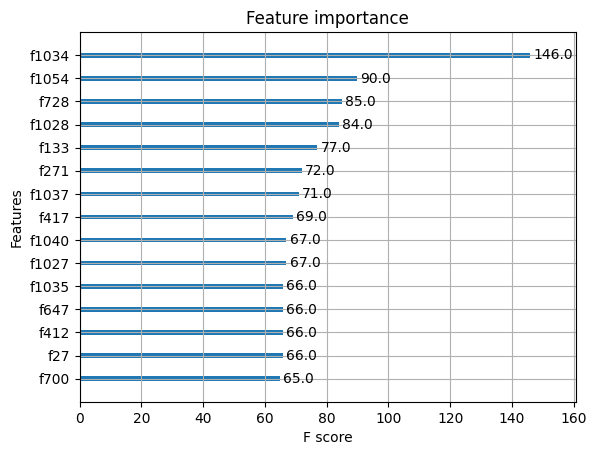

In [66]:
xgb.plot_importance(model,max_num_features=15)

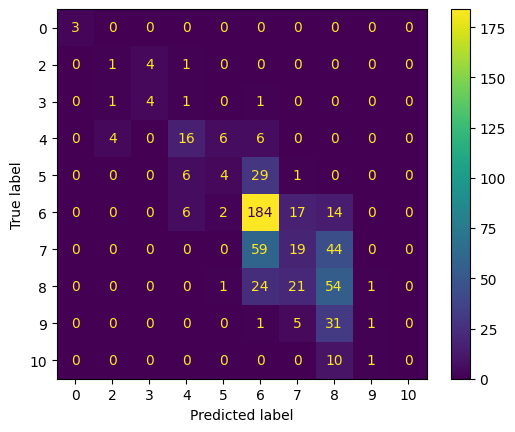

In [67]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(TestY,PredY)
ConfusionMatrixDisplay.from_predictions(TestY,PredY)